In [3]:
!nvidia-smi

Sun Mar  2 17:32:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   56C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
import tensorflow as tf

In [5]:
tf.__version__

'2.18.0'

In [6]:
from tensorflow import keras

In [7]:
keras.__version__

'3.8.0'

In [8]:
from tensorflow.keras.layers import Dense,Flatten,Lambda,Input
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
import numpy as np
from glob import glob


In [25]:
IMAGE_SIZE=[224,224]
base_model=VGG16(include_top=False,weights="imagenet",input_shape=IMAGE_SIZE+[3])

In [26]:
train_path='/content/drive/MyDrive/data/train'
validation_path='/content/drive/MyDrive/data/validation'

In [27]:
from tqdm import tqdm
for layer in tqdm(base_model.layers):
  layer.trainable=False

100%|██████████| 19/19 [00:00<00:00, 29105.83it/s]


In [28]:
for layer in (base_model.layers):
  print(layer,layer.trainable)

<InputLayer name=input_layer_2, built=True> False
<Conv2D name=block1_conv1, built=True> False
<Conv2D name=block1_conv2, built=True> False
<MaxPooling2D name=block1_pool, built=True> False
<Conv2D name=block2_conv1, built=True> False
<Conv2D name=block2_conv2, built=True> False
<MaxPooling2D name=block2_pool, built=True> False
<Conv2D name=block3_conv1, built=True> False
<Conv2D name=block3_conv2, built=True> False
<Conv2D name=block3_conv3, built=True> False
<MaxPooling2D name=block3_pool, built=True> False
<Conv2D name=block4_conv1, built=True> False
<Conv2D name=block4_conv2, built=True> False
<Conv2D name=block4_conv3, built=True> False
<MaxPooling2D name=block4_pool, built=True> False
<Conv2D name=block5_conv1, built=True> False
<Conv2D name=block5_conv2, built=True> False
<Conv2D name=block5_conv3, built=True> False
<MaxPooling2D name=block5_pool, built=True> False


In [29]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [30]:
folder=glob(train_path+'/*')
folder,len(folder)

(['/content/drive/MyDrive/data/train/dog',
  '/content/drive/MyDrive/data/train/cat'],
 2)

In [31]:
model=Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(len(folder),activation='softmax'))

In [34]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,137,986 (80.64 MB)

 Trainable params: 6,423,298 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [36]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [37]:
train_data_gen= ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
validation_data_gen=ImageDataGenerator(rescale=1./255)

In [40]:
training_set= train_data_gen.flow_from_directory(train_path,target_size=IMAGE_SIZE,batch_size=32,class_mode='categorical')

Found 200 images belonging to 2 classes.


In [41]:
testing_set= validation_data_gen.flow_from_directory(validation_path,target_size=IMAGE_SIZE,batch_size=32,class_mode='categorical')

Found 158 images belonging to 2 classes.


In [55]:
history= model.fit(training_set,validation_data=testing_set,epochs=40,steps_per_epoch=len(training_set),validation_steps=len(testing_set))

Epoch 1/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 654ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.8924 - val_loss: 0.2444
Epoch 2/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 762ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.8987 - val_loss: 0.2423
Epoch 3/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 667ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.9051 - val_loss: 0.2444
Epoch 4/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 837ms/step - accuracy: 1.0000 - loss: 9.8814e-04 - val_accuracy: 0.9051 - val_loss: 0.2464
Epoch 5/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 596ms/step - accuracy: 1.0000 - loss: 9.0260e-04 - val_accuracy: 0.8924 - val_loss: 0.2497
Epoch 6/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 635ms/step - accuracy: 1.0000 - loss: 9.2157e-04 - val_accuracy: 0.9051 - val_loss: 0.2490
Epoch 7/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 622ms/step - accuracy: 1.0000 - loss: 8.4824e-04 - val_accuracy: 0.9051 - val_loss: 0.2504
Epoch 8/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 582ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.

In [49]:
import matplotlib.pyplot as plt

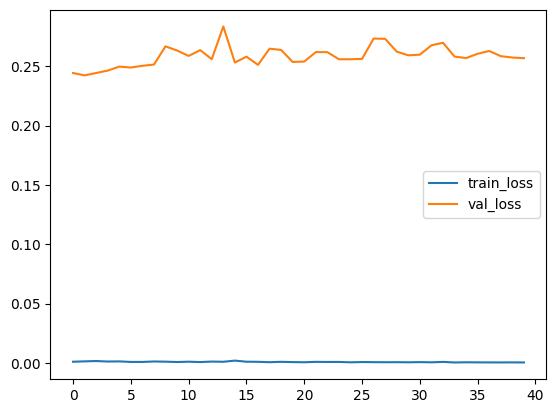

<Figure size 640x480 with 0 Axes>

In [56]:
plt.plot(history.history['loss'],label='train_loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()
plt.savefig('loss.png')

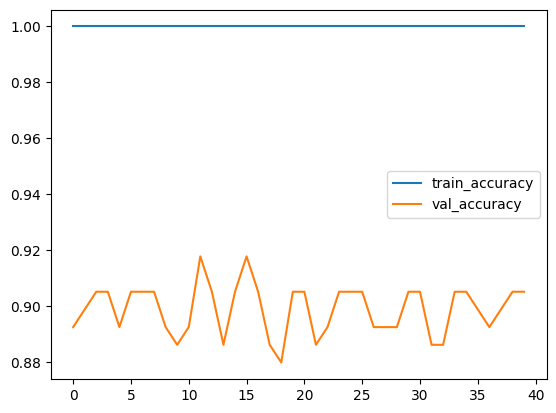

<Figure size 640x480 with 0 Axes>

In [57]:
plt.plot(history.history['accuracy'],label='train_accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.show()
plt.savefig('accuracy.png')

In [58]:
model.save('model.h5')

In [59]:
from tensorflow.keras.models import load_model
model=load_model('model.h5')

In [60]:
y_pred=model.predict(testing_set)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 302ms/step


In [61]:
y_pred

array([[1.73435744e-03, 9.98265684e-01],
       [9.99925137e-01, 7.48615057e-05],
       [5.60051203e-01, 4.39948767e-01],
       [1.37405068e-01, 8.62594903e-01],
       [9.94873703e-01, 5.12625743e-03],
       [9.94351983e-01, 5.64800529e-03],
       [2.62864505e-05, 9.99973655e-01],
       [8.89061749e-01, 1.10938244e-01],
       [1.00000000e+00, 1.03234941e-08],
       [3.38958502e-01, 6.61041439e-01],
       [2.82335648e-04, 9.99717653e-01],
       [5.93532059e-05, 9.99940634e-01],
       [1.53314275e-07, 9.99999881e-01],
       [9.99976516e-01, 2.35237967e-05],
       [1.07277907e-01, 8.92722130e-01],
       [7.10308790e-01, 2.89691269e-01],
       [9.24451715e-09, 1.00000000e+00],
       [9.99998212e-01, 1.83871146e-06],
       [5.07121877e-05, 9.99949336e-01],
       [5.92572311e-11, 1.00000000e+00],
       [9.20328964e-03, 9.90796685e-01],
       [1.87788955e-05, 9.99981165e-01],
       [6.22825027e-01, 3.77174973e-01],
       [6.88386895e-03, 9.93116200e-01],
       [1.077934

In [62]:
np.argmax(y_pred,axis=1)

array([1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 0])